Import necessary libraries

In [8]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import pyplot

from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as score
#(score(y_test, y_pred_knn, normalize=True, sample_weight=None)
from skimage.feature import hog
from skimage import data, exposure

Define helpful function

In [9]:
'''extract only one large, square patch per image and resize it to a fixed size.

Here is a method that preprocesses the image by

-converting to grayscale
-extracting a square patch from the centre
-resize the patch to a given fixed size.'''

def extract_patch(input_image, fixed_size=256):
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    tmp_size = min(gray_image.shape)
    offsets = [(gray_image.shape[i] - tmp_size) // 2 for i in (0, 1)]
    patch = gray_image[offsets[0]: offsets[0] + tmp_size, offsets[1]: offsets[1] + tmp_size]
    return cv2.resize(patch, (fixed_size, fixed_size))

Download data set

In [12]:
from torchvision.datasets import Caltech101
import os, glob

dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')
if not os.path.exists(os.path.join(dset_path, 'caltech101', '101_ObjectCategories')):
    ds = Caltech101(dset_path, download=True)
    
def load_dataset(train_percentage=0.7, maxnum=1000):
    images, labels = [], []
    for labelNum, labelName in enumerate(['emu', 'mayfly']):
        cnt = 0
        image_list = glob.glob(os.path.join(dset_path, 'caltech101', '101_ObjectCategories', labelName, '*.jpg'))
        for imagePath in image_list[:maxnum]:
            images.append(cv2.imread(imagePath))
            labels.append(labelNum)
            cnt += 1
        print('Loaded ', cnt, ' images of class ', labelName)
    np.random.seed(11)
    np.random.shuffle(images)
    np.random.seed(11)
    np.random.shuffle(labels)
    split = int(len(labels) * train_percentage)
    return np.array(images[:split]), np.array(labels[:split]), np.array(images[split:]), np.array(labels[split:])

train_data, train_labels, test_data, test_labels = load_dataset()

Loaded  53  images of class  emu
Loaded  40  images of class  mayfly


<ipython-input-12-b024d3874c7b>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images[:split]), np.array(labels[:split]), np.array(images[split:]), np.array(labels[split:])


Visualise training data set

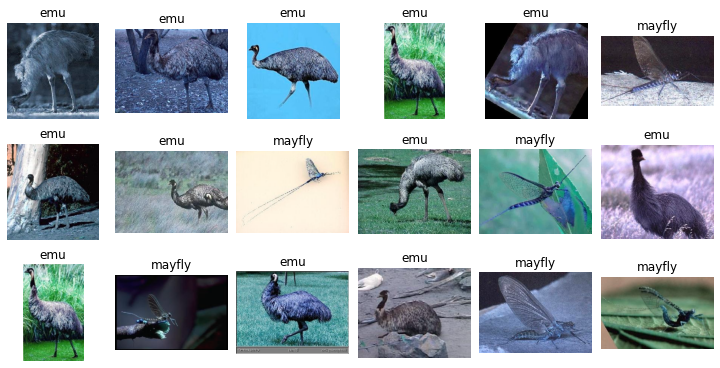

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=6, constrained_layout=True, figsize=(10,5))

label_names = ['emu', 'mayfly']
for ax in axes.flat:
    random_indx = np.random.randint(0, len(train_data))
    img = train_data[random_indx]
    ax.imshow(img)
    ax.set_title(label_names[train_labels[random_indx]])
    ax.axis("off")

In [36]:
#https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8
'''This function prepares the hog's parameters of the training and test data'''
def hog_preparation(train_data, test_data):
    # use a linear SVM, a StandardScaler and return the accuracy!
    fd_train = []
    hog_image_train = []
    #hog_image_train_rescaled
    #print(train_data)
    for image in train_data:
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), # 9 bins of Histogram
                    cells_per_block=(2, 2), visualize=True)
       
        fd_train.append(fd)
        hog_image_train.append(hog_image)

    #print(len(fd_train)) #65
    #new_list = [operation(item) for item in old_list]
    #regular_list = [[1, 2, 3, 4], [5, 6, 7], [8, 9]]
#flat_list = [item for sublist in regular_list for item in sublist]
    fd_train = np.array([item for sublist in fd_train for item in sublist] )  
    fd_train = np.reshape(fd_train,(65,-1))  
    #print("train shape: ", fd_train.shape)
    
    
    fd_test = []
    hog_image_test = []
    
    for image in test_data:
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), # 9 bins of Histogram
                    cells_per_block=(2, 2), visualize=True)
        fd_test.append(fd)
        hog_image_test.append(hog_image)        
        #y=numpy.array([numpy.array(xi) for xi in x])

    #print(len(fd_test))
    fd_test = np.array([item for sublist in fd_test for item in sublist] ) 
    fd_test = np.reshape(fd_test,(28,-1)) 
    #print("test shape: ", fd_test.shape)
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return fd_train, fd_test, hog_image_train, hog_image_test

In [37]:
def resize_image(data):
    resized = []
    for img in data:
        resized.append(cv2.resize(img, (60, 80),interpolation =cv2.INTER_LINEAR))
    return resized


In [38]:
'''def plot_contours(clf, X, y, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    fig, ax = plt.subplots(constrained_layout=True)
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.7)
    
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()'''

'def plot_contours(clf, X, y, **params):\n    """Plot the decision boundaries for a classifier.\n\n    Parameters\n    ----------\n    ax: matplotlib axes object\n    clf: a classifier\n    xx: meshgrid ndarray\n    yy: meshgrid ndarray\n    params: dictionary of params to pass to contourf, optional\n    """\n    fig, ax = plt.subplots(constrained_layout=True)\n    \n    X0, X1 = X[:, 0], X[:, 1]\n    xx, yy = make_meshgrid(X0, X1)\n    \n    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])\n    Z = Z.reshape(xx.shape)\n    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.7)\n    \n    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors=\'k\')\n    ax.set_xlim(xx.min(), xx.max())\n    ax.set_ylim(yy.min(), yy.max())\n    ax.set_xticks(())\n    ax.set_yticks(())\n    plt.show()'

In [39]:
'''This function fit the train/test data (here we use train/test data as HOG features) to the SVM model, predict on test data and give the accuracy of the predicted labels'''
def train_and_test(train_data, train_labels, test_data, test_labels):
    clf = svm.LinearSVC() # SVC = Support Vector Classifier
    # train clf on X_train and y_train
    #print(len(train_data))
    #print(len(train_labels))
    clf.fit(train_data, train_labels)
    labels_pred_svm = clf.predict(test_data)
    accuracy = score(test_labels, labels_pred_svm, normalize=True, sample_weight=None)
    return accuracy, clf, labels_pred_svm

Preprocess the images and calculate the HOG for all images in train and test set

In [40]:
train_data_resized = resize_image(train_data)
test_data_resized = resize_image(test_data)
hog_image_train = []
hog_image_test = []
fd_train, fd_test, hog_image_train, hog_image_test = hog_preparation(train_data_resized, test_data_resized)

Visualise the HOG features

(-0.5, 59.5, 79.5, -0.5)

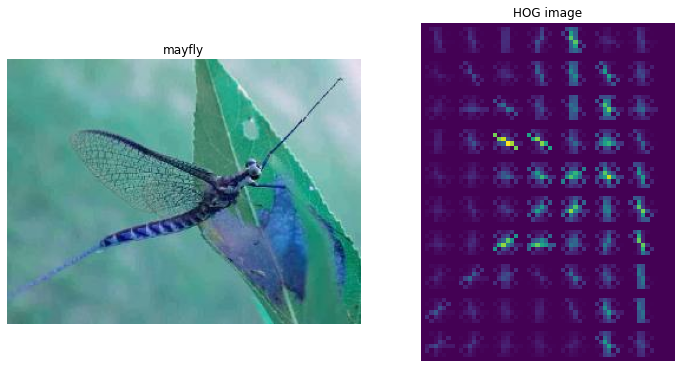

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,5))

random_indx = np.random.randint(0, len(hog_image_train))
img = train_data[random_indx]
axs[0].imshow(img)
axs[0].set_title(label_names[train_labels[random_indx]] )
img_hog = hog_image_train[random_indx]
axs[1].imshow(img_hog)
axs[1].set_title('HOG image')
axs[0].axis('off')
axs[1].axis('off')

Train model

In [42]:
accuracy, clf, labels_pred_svm = train_and_test(fd_train, train_labels, fd_test, test_labels)
print("Model accuracy: ", accuracy)

Model accuracy:  0.8928571428571429


Visualise prediction

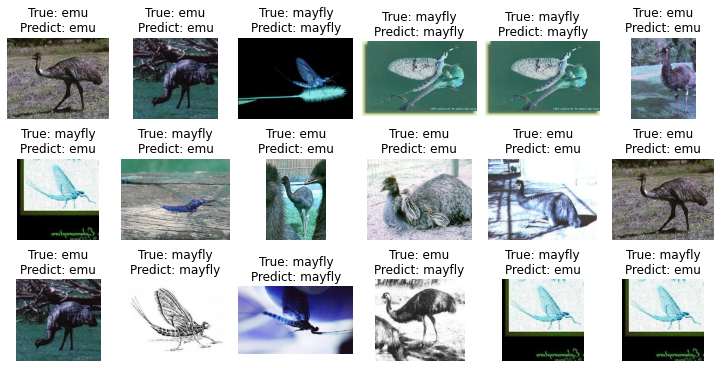

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=6, constrained_layout=True, figsize=(10,5))

for ax in axes.flat:
    random_indx = np.random.randint(0, len(test_data))
    img = test_data[random_indx]
    ax.imshow(img)
    ax.set_title("True: " + label_names[test_labels[random_indx]]+ "\n" + "Predict: " + label_names[labels_pred_svm[random_indx]])
    ax.axis("off")